# Problem 13 Part A
We will begin by implementing the SMO algorithm

In [19]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# the linear kernel as specified in problem 10
def kernel_linear(X):
    return np.dot(X,X.transpose())

# the RBF kernel
def kernel_rbf(X, gamma):
    X_norm = np.sum(X ** 2, axis=-1)
    K = np.exp(-gamma * (X_norm[:, None] + X_norm[None, :] - 2 * np.dot(X, X.T)))
    return K

#input: Y=classification vector, A=lagran multipliers, K=kernel matrix, B=bias, i=index of datapoint
#output: the prediction for the data point i with the given SVM parameters
def predict(Y,A,K,B, i):
    ay = np.multiply(Y, A)
    return np.dot(ay, K[i]) + B

#input: Y=classification vector, A=lagran multipliers, K=kernel matrix, B=bias, i=index of datapoint
#output: the error in the prediction of the SVM for the given point i
def calc_error(Y,A,K,B, i):
    return predict(Y,A,K,B, i) - Y[i]

#input: Y=classification vector, A=lagran multipliers, K=kernel matrix, B=bias
#output: the index of the point in the dataset with maximal error with the given SVM
def choose_point_heuristic(Y,A,K,B):
    N = len(Y)
    #assume 0 is the point with the largest error
    max_err_point = 0
    max_err = calc_error(Y,A,K,B, 0)

    #iterate over all points in the dataset and get the one
    # with the greatest error
    for i in range(1,N):
        Ei = calc_error(Y,A,K,B, i)
        if Ei > max_err:
            max_err = Ei
            max_err_point = i

    return max_err_point

#input: X = training data points, Y = training data points' classification,
# max_passes = the amount of passes to continue without update do before exiting, aka converging
# EPS = threshold for acceptable Lagrange multiplier,
# TOL = tolerance of the error of the hyperplane
# C = margin of error of the SVM
# kernel = name of the kernel to use
# gamma = if using RBF kernel, pass in gamma value for that kernel
#output: vector W and scalar B such that W + [B] is the optimal hyperplane
# found by SMO algorithm
def SMO(X, Y, max_passes=100, EPS=10e-5, TOL=10e-3, C=1, kernel='linear', gamma=1):
    N = len(X) #number of data points
    W = np.zeros(len(X[0]))  # weights
    B = 0  # bais or "threshold"
    A = np.zeros(N)  # lagrange multipliers
    # precalculated kernel values
    if kernel == 'linear':
        K = kernel_linear(X)
    elif kernel == 'RBF':
        K = kernel_rbf(X, gamma)
    else:
        raise 'kernel ' + str(kernel) + ' not available'

    passes = 0

    #converge when we don't update for 100 iterations in a row
    while passes < max_passes:
        updated = False

        for i in range(N):
            Ei = calc_error(Y,A,K,B, i)
            if (Y[i]*Ei < -TOL and A[i] < C) or (Y[i]*Ei > TOL and A[i] > 0):
                j = choose_point_heuristic(Y,A,K,B)
                Ej = calc_error(Y,A,K,B, j)
                ai_old = A[i]
                aj_old = A[j]
                if Y[i] != Y[j]:
                    L = max(0, A[j]-A[i])
                    H = min(C, C+A[j]-A[i])
                else:
                    L = max(0, A[i]+A[j]-C)
                    H = min(C, A[i]+A[j])

                if L == H:
                    continue

                eta = 2*K[i][j] - K[i][i] - K[j][j]
                if eta >= 0:
                    continue

                A[j] = A[j] - Y[j]*(Ei-Ej)/eta
                if A[j] > H:
                    A[j] = H
                elif A[j] < L:
                    A[j] = L

                if abs(A[j] - aj_old) < EPS:
                    continue

                A[i] = A[i] + Y[i]*Y[j]*(aj_old-A[j])

                b1 = B - Ei - Y[i]*(A[i] - ai_old)*K[i][i] - Y[j]*(A[j] - aj_old)*K[i][j]
                b2 = B - Ej - Y[i]*(A[i] - ai_old)*K[i][j] - Y[j]*(A[j] - aj_old)*K[j][j]

                if A[i] > 0 and A[i] < C:
                    B = b1
                elif A[j] > 0 and A[j] < C:
                    B = b2
                else:
                    B = (b1+b2)/2

                W = W + Y[i] * (A[i] - ai_old) * X[i] + Y[j] * (A[j] - aj_old) * X[j]
                updated = True

            #if we didn't update the SVM, increase the passes so we know when we've
            #done max_passes passes without updating
            if not updated:
                passes += 1
            else: #if we've done an, update reset passes
                passes = 0

    #return the hyperplane
    return W, B

For our implementaion we used the convergence criteria a simple check if 
we have done a certain amout of passes of the algorithm without updating the SVM.
We calculate the threshold (b) similar as specified in the Platt's article except we subtract from B instead of add in order to adhere to the constraints 0 < an < C for each n in our implementation.
And for the second point hueristic we choose to pick the point with the largest error as that point will make the biggest impact on our weights.

Now that we have our SMO algorithm we will run a quick test to make sure everything works correctly, we will generate a random dataset that is 'almost' linearly separable and run the SMO on it. for that we will first define a function to generate said dataset and test it using different parameters

In [20]:
#input: random object to use, value range
#output: random number within the defined value range
def randInRange(rand,value_range):
    return rand.uniform(-value_range,value_range)

#input: n = number of points in the dataset, d = dimension of points,
# non_sep_ratio = the rough % of points to violate linear separability
#output: the array of point vectors and array of thier classification
# corresponding by index with ~5% of the points violating linear separability
def generate_semi_seperable_data(n, d, non_sep_ratio, value_range=100, random_seed=None):
    #generate a random line
    if random_seed != None:
        rand = np.random.default_rng(random_seed)
    else:
        rand = np.random
    line = np.array([ rand.uniform(0, 5) for _ in range(d) ] + [randInRange(rand,value_range)])
    points = []
    classifications = []

    for i in range(n): #loop n times
        point = [randInRange(rand,value_range) for _ in range(d) ]+[1] #generate a random point in space
        dist = np.dot(line, point)
        classification = 1 if dist > 0 else -1 #clasify point based of generated line
        #decide if a point will violate linear separability by probability of 5%
        if rand.uniform() <= non_sep_ratio:
            classification *= -1 #flip the classification from "correct" to "violating"
        points.append( [point[0],point[1]] ) #add point and it's classification to the dataset
        classifications.append( classification ) #add the points classification

    return np.array( points ), np.array( classifications )

#input: W= weight vector, B = bias, X=dataset points, Y=dataset classification
# ax0=index of the first axis to plot, ax1= index of the second axis to plot
#output: a 2d scatter plot of the datapoints by the axis index provided colored by
# classification with a hyperplane plot
def scatter_line(W, b, X, Y, ax0, ax1):
    px = X.transpose()[ax0]
    py = X.transpose()[ax1]

    xlim = (np.min(px),np.max(px))
    ylim = (np.min(py),np.max(py))

    lx = np.linspace(xlim[0], xlim[1], 10)
    f = [W[ax0],W[ax1],b]
    fy = -(f[0]/f[1])*lx - (f[2]/f[1])

    dotColors = np.array([ (mcolors.BASE_COLORS['r'] if y > 0 else mcolors.BASE_COLORS['b']) for y in Y])

    # plot
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6)
    fig.set_dpi(100)

    ax.plot(lx, fy, linewidth=2.0, label="f", color=mcolors.BASE_COLORS['k'])

    ax.scatter(px, py, c=dotColors)
    #set axis range
    ax.set(xlim=xlim,
           ylim=ylim )

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    plt.show()

#tests the SMO algorithm using the given parameters
def test(C=0.01, sample_size=500, dimension=2, non_sep_ratio=0.05, value_range=10):
    X, Y = generate_semi_seperable_data(sample_size, dimension, non_sep_ratio, value_range)
    W,B = SMO(X, Y, C=C)
    return W,B,X,Y

now we execute a quick test and expect SMO to find a decent hyperplane for the generated dataset. we will verify the result with a  visual inspection on the plotted hyperplane

[0.69471537 0.47807031] -7.246962241701148


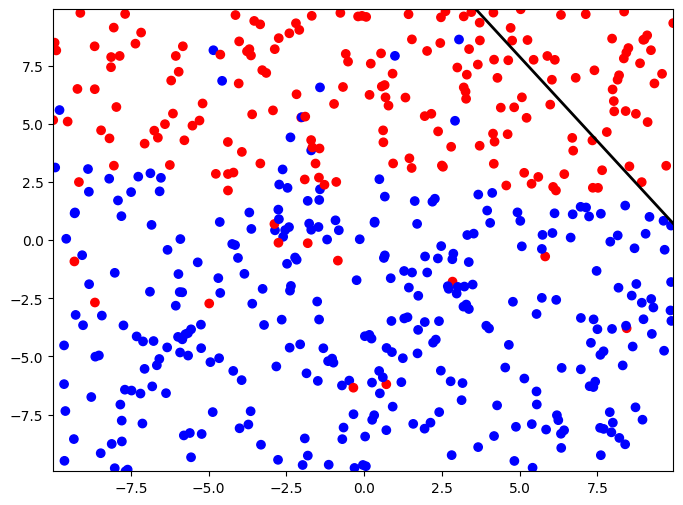

In [6]:
W,B,X,Y = test(C=1)
print(W,B)
scatter_line(W, B, X, Y ,0 ,1)

Unfortunately we get pretty erratic and random hyperplanes where some separare the data poorly and some don't at all, some don't even show on the graph because the bias is so far off. This is probably a result of error in implementation and/or usage of the SMO but unfortunately I was unable to find the error. 

# Problem 13 Part B
in this part we will us the SMO algorithm we implemented in part A and try to build a multiclass classification model to the iris dataset from sklearn. 

## Problem 13 PartB I
we begin by ploting a scatterplot matrix of the iris dataset.

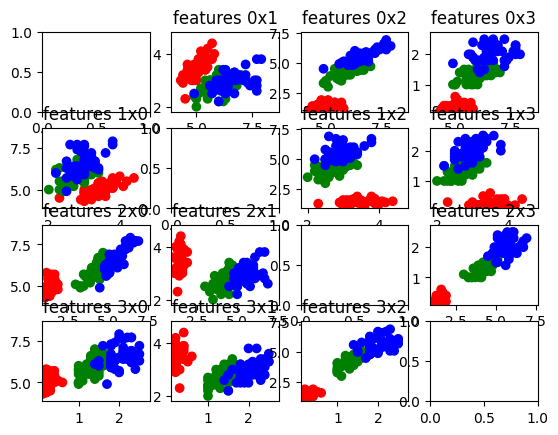

In [7]:
#input: ax= matplotlib axis array, X = dataset, ax0=index of x axis, ax1=index of y axis, 
# colors=matplotlib color name matrix
#output: adds a scatterplot graph to the plot of the given dataset along
# the given axis in the position relative to the given axis
def scatter_plot(ax, X, ax0, ax1, colors):
    px = X.transpose()[ax0]
    py = X.transpose()[ax1]

    xlim = (np.min(px)*0.9, np.max(px)*1.1)
    ylim = (np.min(py)*0.9, np.max(py)*1.1)

    ax[ax0,ax1].scatter(px, py, c=colors)
    # set axis range
    ax[ax0,ax1].set(xlim=xlim,
           ylim=ylim)
    ax[ax0,ax1].set_title("features "+str(ax0)+"x"+str(ax1))

#load the iris data set
iris = datasets.load_iris()
X = iris.data
Y = iris.target

#create a matrix of 4x4 graphs since we have 4 features in each data point
figure, axis = plt.subplots(4, 4)
dotColors = np.array(50*['r']+50*['g']+50*['b'])
#create the individual graphs for each axis 
for i in range(4):
  for j in range(4):
    if i != j:
      scatter_plot(axis, X, i, j, dotColors)

#display the graph matrix
plt.show()

from this matrix it's possible to see that the feature pairs (0,2),(1,2),(1,3) look pretty separable while the feature pairs (0,3),(1,3),(2,3) look not linearly separable

## Problem 13 Part B J
we will now train 3 SVMs on the dataset on a policy of one-vs-many meaning we will split the dataset 3 times where each time one class will be classified as 1 and the other two will be classified as -1. to do this we will first split the dataset into train, validation, and test sets and for each set we will split the classification vector as speificeid for each class. we will then train an SVM for each class for each value of C in a specified range to find the optimal value of C for each class.
first we define a function to do the one to many split and a function to train the SVM and find the optimal C

In [21]:
#input: y_type= the number of the class, Y= the classification vector of the
# dataset
#output: returns a new classification vector where for every index of a data point
# that is on the class y_type, there will be a 1 and for all other indexes there will
# be a -1
def to_one_v_many(y_type, Y):
    new_Y = []

    for y in Y:
        if y == y_type:
            new_Y.append(1)
        else:
            new_Y.append(-1)

    return new_Y

#input: X and Y of the training and validation set, hyperparameters including kernel and a 
# range for each hyper parameter we must optimise
#output: a hyperplane train on the training using the optimal paramters in the range 
# that where found by validating on the validation set. the last element of the hyperplane 
# will be the bias
def train_validate_svm(X_train,Y_train,X_valid,Y_valid,C_RANGE,kernel="linear",GAMMA_RANGE=None,max_passes=100):
    #append 1 to each data point for easly doing dot product with bias
    X_valid = np.concatenate((X_valid.transpose(), [np.ones(len(X_valid))])).transpose()
    N_valid = len(X_valid)

    #minial number of misclassified points in the validation set. start from max to get min
    min_err = N_valid
    best_param = 0 #best optimising parameters
    best_hyp = [] #best hyperplane

    hyp_param = [] #list of hyperplane, optimising paramter pairs
    for C in C_RANGE:
        if kernel == 'linear': #in case of linear kernel we can only optimise over C
            W, B = SMO(X_train, Y_train, C=C, kernel=kernel,max_passes=max_passes)
            hyp = np.append(W, B)
            if np.any(hyp):
                hyp_param.append([hyp, C])

        elif kernel == 'RBF' :
            for G in GAMMA_RANGE: #in case of RDF kernel we can optimise both C and gamma
                W, B = SMO(X_train, Y_train, C=C, kernel=kernel, gamma=G, max_passes=max_passes)
                hyp = np.append(W, B)
                if np.any(hyp):
                    hyp_param.append((hyp, (C, G)))
        else: #other kernels not implemented
            raise 'Unsupported kernel function '+kernel

    #test each hyperplane we trained and save the params and hyperplane
    #which misclassified the least number of data points in the validation set
    for attempt in hyp_param:
        hyp = attempt[0]
        param = attempt[1] #will be just C in case of linear kernel

        #do yn*(w.T*xn + b) for each point in validation set, and
        #convert the vector to a vector where 1 for index with positive value 
        #and -1 for index with negative value
        err = np.sign(np.multiply(Y_valid, np.dot(X_valid,hyp)))
        # add -1 to each value so 1 turns to 0 and -1 turns to -2
        err = err + -1*np.ones(N_valid)
        #now we have a vector with -2 for each misclassified point and 0
        #for each correctly classified point, the sum will be -2*Number Of Misclassified
        #we mutiply by -1/2 to get -1/2*-2*NOM = NOM
        err = -0.5 * np.sum( err )

        #take this one if it misclassified less points than the prevoius
        if err < min_err:
            min_err = err
            best_hyp = hyp
            best_param = param
    #if we want we can see the % of points we got right in the validation set
    #success_rate = 1 - min_err/N_valid
    #print("best hyperparameter value=", best_param, "with success rate=",success_rate)
    return best_hyp, best_param

Next we will apply the functions in order to split the data and train on it

In [25]:
#split the data into training, validation, and test sets and for each
#class using a 60 20 20 split and generate a one vs many  binary classification
#vector for each set. also shuffle the point to make sure we get some of each type
#in every set
X_train, X_val_test, Y_train, Y_val_test = train_test_split(X, Y, train_size=0.6, shuffle=True)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_val_test, Y_val_test, train_size=0.5)

Y0_train = to_one_v_many(0, Y_train)
Y1_train = to_one_v_many(1, Y_train)
Y2_train = to_one_v_many(2, Y_train)

Y0_valid = to_one_v_many(0, Y_valid)
Y1_valid = to_one_v_many(1, Y_valid)
Y2_valid = to_one_v_many(2, Y_valid)

Y0_test = to_one_v_many(0, Y_test)
Y1_test = to_one_v_many(1, Y_test)
Y2_test = to_one_v_many(2, Y_test)

#run the training and do validation. For each class, get an optimal C and hyperplane
C_RANGE = np.arange(1/len(X),1,0.01)

hyp0, C0 = train_validate_svm(X_train, Y0_train, X_valid, Y0_valid,C_RANGE)
print("class 0 got hyperplane ",hyp0, " with optimal C of",C0)
hyp1, C1 = train_validate_svm(X_train, Y1_train, X_valid, Y1_valid,C_RANGE)
print("class 1 got hyperplane ",hyp1, " with optimal C of",C1)
hyp2, C2 = train_validate_svm(X_train, Y2_train, X_valid, Y2_valid,C_RANGE)
print("class 2 got hyperplane ",hyp2, " with optimal C of",C2)

class 0 got hyperplane  [-0.01        0.014      -0.032      -0.01266667  0.08883333]  with optimal C of 0.006666666666666667
class 1 got hyperplane  [ 0.10122309 -0.4916179   0.03019609 -0.11339226  0.5533978 ]  with optimal C of 0.4966666666666666
class 2 got hyperplane  [ 0.01933333 -0.00133333  0.04533333  0.012      -0.37396667]  with optimal C of 0.006666666666666667


## Problem 13 Part B K
We will now use the hyperplanes we trained to compose a model for predicting a given data points classification. the model will be a 3x5 matrix such that each row is a hyperplane of a class, therefore the dot product of a point by the matrix will yeild a classification for that point by each hyperplane. The hyperplane that classified the point as a positive will be the one who's most likely of the class of the point. When more than one hyperplanes classify the point as positive we will looke a the dot product as a certainty value and take the maximum between them. 
We will now define a function to predict the model and then use the model to build a confusion matrix by predicting the test set.


In [26]:
#input: model= matrix of hyperplanes, one for each class, x= a data point
#output: the class of the model predicts for the given datapoint
def classify(model, x):
    predictions = np.dot(model,x) #predict using all hyperplanes
    return np.argmax(predictions) #take the index of the hyperplane with the largest certainty

#the model
model = np.array([hyp0, hyp1, hyp2])

#append a 1 to each data point to easly do dot product with hyperplane (for the bias)
X_test = np.concatenate((X_test.transpose(), [np.ones(len(X_test))])).transpose()

#the confusion matrix
confusion_mat = [[0,0,0],[0,0,0],[0,0,0]]

for i in range(len(X_test)):
    pred = classify(model, X_test[i])
    actual = Y_test[i]
    confusion_mat[actual][pred] += 1

print("confusion matrix\n",
      "0:", confusion_mat[0], '\n',
      "1:", confusion_mat[1], '\n',
      "2:", confusion_mat[2])

confusion matrix
 0: [9, 0, 0] 
 1: [2, 0, 7] 
 2: [0, 0, 12]


we see that there is one hyperplane that overpowers the others so the model mostly predicts one class. This maybe a sign of an error in the implementation and/or usage of the SMO, unfortunately I was unable to find the issue and these are the result I got.

## Problem 13 Part B L
now we will use the confusion table we generated to calculate the sensitivity for each class in the model and also the confusion table for each class.

In [27]:
confusion_tables = []
sensitivities = []
for i in range(3):
    TP = confusion_mat[i][i]
    FP = 0
    for j in range(3):
        if j != i:
            FP += confusion_mat[j][i]
    FN = sum(confusion_mat[i]) - TP
    TN = 0
    for j in range(3):
        if j != i:
            TN += sum(confusion_mat[j])-confusion_mat[j][i]
    sensitivity = TP/(TP+FN)
    confusion_tables.append([TP,FP,FN,TN])
    sensitivities.append(sensitivity)

print("confusion tables",confusion_tables)
print("sensitivities",sensitivities)


confusion tables [[9, 2, 0, 19], [0, 0, 9, 21], [12, 7, 0, 11]]
sensitivities [1.0, 0.0, 1.0]


As we can see we get the error of our SVM reflected in the confusion table.
The sensitivy of the last class is 0 and therefore the SVM does not detect it
which we also saw in the confusion matrix where as the other 2 classes get detected

## Problem 13 Part B M
In this part we will retrain and validate the model this time using the RBF kernel and optimising the parameter gamma of the RBF function while using the C paramter from our previous runs to save time. Then we will recalculate the confusion and sensitivities and compare the results to the linear kernel

In [28]:
X_train, X_val_test, Y_train, Y_val_test = train_test_split(X, Y, train_size=0.6, shuffle=True)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_val_test, Y_val_test, train_size=0.5)

Y0_train = to_one_v_many(0, Y_train)
Y1_train = to_one_v_many(1, Y_train)
Y2_train = to_one_v_many(2, Y_train)

Y0_valid = to_one_v_many(0, Y_valid)
Y1_valid = to_one_v_many(1, Y_valid)
Y2_valid = to_one_v_many(2, Y_valid)

Y0_test = to_one_v_many(0, Y_test)
Y1_test = to_one_v_many(1, Y_test)
Y2_test = to_one_v_many(2, Y_test)

GAMMA_RANGE = np.arange(1/len(X),1,0.1)

hyp0, params0 = train_validate_svm(X_train, Y0_train, X_valid, Y0_valid,[C0],kernel='RBF',GAMMA_RANGE=GAMMA_RANGE,max_passes=10)
print("class 0 got hyperplane ",hyp0, " with optimal params of",params0)
hyp1, params1 = train_validate_svm(X_train, Y1_train, X_valid, Y1_valid,[C1],kernel='RBF',GAMMA_RANGE=GAMMA_RANGE,max_passes=10)
print("class 1 got hyperplane ",hyp1, " with optimal params of",params1)
hyp2, params2 = train_validate_svm(X_train, Y2_train, X_valid, Y2_valid,[C2],kernel='RBF',GAMMA_RANGE=GAMMA_RANGE,max_passes=10)
print("class 2 got hyperplane ",hyp2, " with optimal params of",params2)

X_test = np.concatenate((X_test.transpose(), [np.ones(len(X_test))])).transpose()

model = np.array([hyp0, hyp1, hyp2])

confusion_mat = [[0,0,0],[0,0,0],[0,0,0]]

for i in range(len(X_test)):
    pred = classify(model, X_test[i])
    actual = Y_test[i]
    confusion_mat[actual][pred] += 1

confusion_tables = []
sensitivities = []
for i in range(3):
    TP = confusion_mat[i][i]
    FP = 0
    for j in range(3):
        if j != i:
            FP += confusion_mat[j][i]
    FN = sum(confusion_mat[i]) - TP
    TN = 0
    for j in range(3):
        if j != i:
            TN += sum(confusion_mat[j])-confusion_mat[j][i]
    sensitivity = TP/(TP+FN)
    confusion_tables.append([TP,FP,FN,TN])
    sensitivities.append(sensitivity)

print("confusion matrix RBF\n",
      "0:", confusion_mat[0], '\n',
      "1:", confusion_mat[1], '\n',
      "2:", confusion_mat[2])
print("confusion tables RBF",confusion_tables)
print("sensitivities RBF",sensitivities)

class 0 got hyperplane  [-5.33333333e-03  8.00000000e-03 -2.73333333e-02 -9.33333333e-03
 -5.85571518e-05]  with optimal params of (0.006666666666666667, 0.006666666666666667)
class 1 got hyperplane  [-0.09933333  0.04966667  0.04966667 -0.04966667 -0.06543918]  with optimal params of (0.4966666666666666, 0.006666666666666667)
class 2 got hyperplane  [ 0.004       0.00133333  0.01533333  0.01133333 -0.00014647]  with optimal params of (0.006666666666666667, 0.006666666666666667)
confusion matrix RBF
 0: [0, 0, 10] 
 1: [0, 0, 10] 
 2: [0, 0, 10]
confusion tables RBF [[0, 0, 10, 20], [0, 0, 10, 20], [10, 20, 0, 0]]
sensitivities RBF [0.0, 0.0, 1.0]


As we can see, the RBF kernel yields different hyperplanes but the problem we have in the still persists.